# **Installation of libraries**

In [44]:
!pip install torch lightning numpy kaggle wandb sklearn
!pip install polars  -U
!pip install -U torch-geometric
#!pip install git+https://github.com/rusty1s/pytorch_geometric.git

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


# **Import dataset**

In [2]:
from google.colab import files

# Carica il file kaggle.json
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"alexxxyy47","key":"1f2860ea591d24fc6810f02a5403dd91"}'}

In [3]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [4]:
!kaggle datasets download -d ealaxi/paysim1
!unzip paysim1.zip
!rm paysim1.zip
!mkdir models

 98% 174M/178M [00:01<00:00, 84.3MB/s]
100% 178M/178M [00:01<00:00, 99.0MB/s]
Archive:  paysim1.zip
  inflating: PS_20174392719_1491204439457_log.csv  


# **Imports**

In [74]:
import pandas as pd, sys, plotly.graph_objects as go, plotly.express as px, numpy as np, torch, random as rnd, torch.nn as nn, lightning as l, wandb as wndb
from torch.utils.data import Dataset, DataLoader
from sklearn.utils import shuffle
from torch_geometric import seed_everything
import polars as pl
from torch_geometric.data import Data
import pdb
from torch_geometric.nn import GCNConv
import torchmetrics
from torch.nn import Linear, ReLU
from torch_geometric.nn import Sequential  as GSequential, GCNConv, GATConv
from torchmetrics.classification import BinaryAccuracy, BinaryF1Score, BinaryPrecision, BinaryRecall, BinaryConfusionMatrix
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.metrics import  confusion_matrix as compute_confusion_matrix, ConfusionMatrixDisplay

In [ ]:
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# **Setting some parameters**

In [6]:
# PARAMETERS

DEVICE = "cuda"
SEED = 42

rnd.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
#torch.backends.cudnn.deterministic = False
# torch.backends.cudnn.deterministic = True
seed_everything(SEED)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
ACCELERATOR =  "gpu" if torch.cuda.is_available() else "cpu"
POS_SIZE = 150
NEG_SIZE = 1200



# **Utils functions**

In [7]:
# -------------UTILS FUNCTIONS--------------

def load_dataframe( dataset_file : str):
    return pl.read_csv(dataset_file)


def find_null_or_empty_records( dataframe: pd.DataFrame):
    n = len(dataframe)
    for index, row in dataframe.iterrows():
        print_progress_bar(index/n)
        # Controlla se ci sono valori nulli o vuoti nel record
        if row.isnull().any() or any(map(lambda x: x == '', row)):
            # Stampa il record
            print(f"Record con valori nulli o vuoti:\n{row}\n")

def print_progress_bar(percentuale, lunghezza_barra=20):
    blocchi_compilati = int(lunghezza_barra * percentuale)
    barra = "[" + "=" * (blocchi_compilati - 1) + ">" + " " * (lunghezza_barra - blocchi_compilati) + "]"
    sys.stdout.write(f"\r{barra} {percentuale * 100:.2f}% completo")
    sys.stdout.flush()


def compute_kind_inconsistence(dataframe):
    return {"inconsistent orig balance": len(dataframe.query('abs(oldbalanceOrg - newbalanceOrig) != amount'))/len(dataframe),
            "inconsistent dest balance": len(dataframe.query('abs(oldbalanceDest - newbalanceDest) != amount'))/len(dataframe),
            "zero cash transaction": len(dataframe.query('amount == 0 '))/len(dataframe),
            "self-transaction": len(dataframe.query('nameOrig == nameDest'))/len(dataframe)
            }

def plot_histogram(to_plot):


    # Converti il dizionario in un array di valori
    values = list(to_plot.values())

    # Crea un istogramma
    fig = go.Figure(data=[go.Bar(x=list(to_plot.keys()), y=values)])

    # Mostra l'istogramma
    fig.show()



def plot_graph(nodes, edges):

    # Esempio di utilizzo
    graph = nx.Graph()
    graph.add_nodes_from(nodes)
    graph.add_edges_from(edges)


    # Crea un layout per il grafo
    pos = nx.spring_layout(graph)

    # Disegna i nodi
    nx.draw_networkx_nodes(graph, pos, node_color='skyblue', node_size=500)

    # Disegna gli archi
    nx.draw_networkx_edges(graph, pos, edge_color='gray')

    # Etichetta i nodi
    nx.draw_networkx_labels(graph, pos, font_size=12, font_color='black')

    # Mostra il grafo
    plt.title("Plot del Grafo")
    plt.axis('off')
    plt.show()




def plot_histogram_percentages(data, labels):

    # Verifica che la lunghezza dei dati e delle etichette sia la stessa
    if len(data) != len(labels):
        raise ValueError("Le liste 'data' e 'labels' devono avere la stessa lunghezza.")

    # Crea un istogramma con Plotly Express
    fig = px.bar(x=labels, y=data, text=data, title='Data percentages',
                 labels={'x': 'About', 'y': 'Percentage'})

    # Aggiungi etichette sull'istogramma
    fig.update_traces(texttemplate='%{text:.5%}', textposition='outside')

    # Mostra il plot
    fig.show()


def plot_categories(dataframe):
    # Calcola la frequenza di ogni categoria nella colonna 'type'
    counts = dataframe.group_by('type').agg(pl.col('type').count().alias('count')).sort('count')

    # Normalizza i conteggi
    counts = counts.with_columns(counts['count'] / counts['count'].sum())

    # Crea l'istogramma con Plotly Express
    fig = px.bar(counts.to_pandas(), x='type', y='count', title='percentage of data for different categories of the column "type"')

    # Mostra il plot
    fig.show()

def create_name_dict(df):
  df1 = df.select(pl.col("nameOrig").alias('name'))
  df2 = df.select(pl.col("nameDest").alias('name'))
  df = pl.concat([df1,df2])
  df = df.unique()
  names = list(df['name'])
  return dict(zip(names,list(range(len(names)))))


def divide_dataset(dataset_file,train_prc,val_prc):
  #breakpoint()
  dataframe = load_dataframe(dataset_file)
  transaction_types = {
      "CASH_IN": 0,
      "CASH_OUT": 1,
      "DEBIT": 2,
      "PAYMENT": 3,
      "TRANSFER": 4
  }

  dataframe = dataframe.with_columns(pl.col("type").replace(transaction_types).cast(pl.Int64).alias("type"),
                                     (pl.col('step')%24).alias('step'))

  id_df  = pl.DataFrame({'id': list(range(len(dataframe)))})

  dataframe = pl.concat([dataframe, id_df], how="horizontal")

  d_neg = dataframe.filter((pl.col('amount') != 0) & (pl.col('isFraud') == 0))
  neg_data_train = d_neg.sample(int(len(d_neg)*train_prc))
  d_neg = d_neg.filter(~pl.col('id').is_in(neg_data_train.select(pl.col('id'))))

  d_pos = dataframe.filter((pl.col('amount') != 0) & (pl.col('isFraud') == 1))
  pos_data_train = d_pos.sample(int(len(d_pos)*train_prc))
  d_pos = d_pos.filter(~pl.col('id').is_in(pos_data_train.select(pl.col('id'))))


  neg_data_val = d_neg.sample(int(len(d_neg)*val_prc))
  d_neg = d_neg.filter(~pl.col('id').is_in(neg_data_val.select(pl.col('id'))))

  pos_data_val = d_pos.sample(int(len(d_pos)*val_prc))
  d_pos = d_pos.filter(~pl.col('id').is_in(pos_data_val.select(pl.col('id'))))

  neg_data_train = neg_data_train.select(pl.exclude('id'))
  pos_data_train = pos_data_train.select(pl.exclude('id'))

  neg_data_val = neg_data_val.select(pl.exclude('id'))
  pos_data_val = pos_data_val.select(pl.exclude('id'))

  d_neg = d_neg.select(pl.exclude('id'))
  d_pos = d_pos.select(pl.exclude('id'))

  return (neg_data_train, pos_data_train), (neg_data_val, pos_data_val), (d_neg,d_pos )

def list_to_dataframe(data):
  rows = []
  for row in data:
    el = {
        'step': row[0],
        'type': int(row[1]),
        'amount': row[2] ,
        'nameOrig': row[3],
        'oldbalanceOrg': row[4],
        'newbalanceOrig': row[5],
        'nameDest': row[6],
        'oldbalanceDest': row[7],
        'newbalanceDest': row[8],
        'isFraud': row[9],
        'isFlaggedFraud': row[10]
     }
    rows.append(el)
  return pl.DataFrame(rows)



def collate( data ):
  if type(data) is list:
  #breakpoint()
    data = list_to_dataframe(data)


  name_d = create_name_dict(data)
  x = torch.tensor([[1] if y.startswith("M") else [0] for y in name_d.keys()], dtype=torch.float).to(DEVICE)
  data = data.with_columns(pl.col('nameOrig').replace(name_d).cast(pl.Int64).alias('nameOrig'), pl.col('nameDest').replace(name_d).cast(pl.Int64).alias('nameDest'))
  edges = data.select(pl.col('nameOrig','nameDest'))
  edge_index = torch.tensor(edges.to_numpy(), dtype=torch.int64).t().contiguous().to(DEVICE)
  y = torch.tensor(data.select(pl.col('isFraud')).to_numpy(), dtype=torch.float).to(DEVICE)
  #edge_attr =  torch.tensor(data.select(pl.col('amount')).to_numpy(), dtype=torch.float).to(self.device)
  edge_attr =  torch.tensor(data.select(pl.col('step','type','amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest')).to_numpy(), dtype=torch.float).to(DEVICE)
  data_graph = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
  return data, data_graph


def analize_data(data):

    print("----HEAD----")
    print(data.head())
    print("----DESCRIBE----")
    print(data.describe())
    plot_categories(data)
    labels = []
    percentages = []
    print("COLUMNS NAMES AND TYPES = ", list(zip(data.columns, data.dtypes)))

    print("NUMBER OF NODES = ", pl.DataFrame({"names": pl.concat([data['nameDest'] ,
                                      data['nameOrig']])}).select("names").unique().height)
    print("NUMBER OF EDGES = ", data.height)
    prc_frauds = data.filter(pl.col('isFraud') == 1).height / data.height
    print("PERCENTAGE OF FRAUDS = ", prc_frauds)
    percentages.append(prc_frauds)
    labels.append("prc_fraud")
    prc_flagged_fraud = data.filter(pl.col('isFlaggedFraud') == 1).height / data.height
    print("PERCENTAGE OF FLAGGED FRAUD = ",prc_flagged_fraud )
    percentages.append(prc_flagged_fraud)
    labels.append("prc_flagged_fraud")
    prc_flagged_fraud_and_real_fraud = data.filter(pl.col('isFlaggedFraud') == 1).height /        \
          data.filter((pl.col('isFraud') == 1) & (pl.col('isFlaggedFraud') == 1)).height
    print("PERCENTAGE OF FLAGGED AS FRAUD WHICH ARE FRAUDS = ",prc_flagged_fraud_and_real_fraud)
    percentages.append(prc_flagged_fraud_and_real_fraud)
    labels.append("prc_flagged_fraud_which_are_real_fraud")
    print("----ANOMALIES----")

    anomalies = data.filter( ( (abs(pl.col('oldbalanceOrg') - pl.col('newbalanceOrig')) !=
                        abs(pl.col('oldbalanceDest') - pl.col('newbalanceDest'))) &
                        (~pl.col('nameDest').str.starts_with('M')) ) |
                      (pl.col('amount') == 0) |
                        (pl.col('nameOrig') == pl.col('nameDest')))
    print("PERCENTAGE OF ANOMALIES = ", anomalies.height / data.height)
    percentages.append(anomalies.height / data.height)
    labels.append("prc_anomalies")
    prc_given_gt_received = data.filter( ( abs(pl.col('oldbalanceOrg') - pl.col('newbalanceOrig')) >  \
                        abs(pl.col('oldbalanceDest') - pl.col('newbalanceDest')) ) &   \
                        ~(pl.col('nameDest').str.starts_with('M')) ).height / data.height
    print("PERCENTAGE OF ANOMALIES [MONEY GIVEN > MONEY RECEIVED] = ",prc_given_gt_received)
    percentages.append(prc_given_gt_received)
    labels.append("prc_anomaly_given_money_greater_than_received")

    prc_given_lt_received = data.filter( ((abs(pl.col('oldbalanceOrg') - pl.col('newbalanceOrig')) <   \
                          abs(pl.col('oldbalanceDest') - pl.col('newbalanceDest'))) &      \
                          ~(pl.col('nameDest').str.starts_with("M")))  ).height / data.height
    print("PERCENTAGE OF ANOMALIES [MONEY RECEIVED > MONEY GIVEN] = ",prc_given_lt_received)
    percentages.append(prc_given_lt_received)
    labels.append("prc_anomaly_given_money_less_than_received")
    prc_no_amount = data.filter(pl.col('amount') == 0).height / data.height
    print("PERCENTAGE OF ANOMALIES [AMOUNT = 0] = ", prc_no_amount)
    percentages.append(prc_no_amount)
    labels.append("prc_anomaly_0_amount")
    prc_self_transaction = data.filter(pl.col('nameOrig') == pl.col('nameDest')).height / data.height
    print("PERCENTAGE OF ANOMALIES [ORIGIN = DESTINATION] = ",prc_self_transaction)
    percentages.append(prc_self_transaction)
    labels.append("prc_anomaly_self_transaction")
    prc_frauds_inside_anomalies = anomalies.filter(pl.col('isFraud') == 1).height / data.filter(pl.col('isFraud') == 1).height
    print("PERCENTAGE OF TOTAL FRAUDS INSIDE ANOMALIES = ",prc_frauds_inside_anomalies)
    percentages.append(prc_frauds_inside_anomalies)
    labels.append("prc_of_total_frauds_inside_anomalies")


    plot_histogram_percentages(percentages, labels)



def produce_att(att):
  edge_index = att[0]
  attention = att[1]
  node_names = []
  node_weights = []
  edge_names = []
  edge_weights = []
  for i in range(len(attention)):
    n1 = int(edge_index[0][i])
    n2 = int(edge_index[1][i])
    if n1 == n2:
      node_names.append(str(n1))
      node_weights.append(float(attention[i]))
    else:
      edge_names.append((str(n1), str(n2)))
      edge_weights.append(float(attention[i]))
  return node_names, node_weights, edge_names, edge_weights


def visualize_attention(attention, edge_index, num_nodes, head_idx):
  attention = attention[head_idx].detach().cpu().numpy()
  attention = attention.reshape(attention.shape[0], -1)
  attention = attention / attention.sum(axis=1)[:, None]
  fig, axes = plt.subplots(1, 2, figsize=(10, 5))
  axes[0].spy(edge_index.numpy(), markersize=1)
  axes[0].set_title('Edge Index')
  axes[1].imshow(attention, cmap='coolwarm')
  axes[1].set_title(f'Attention (Head {head_idx + 1})')
  plt.show()



# **Some Analysis**

In [8]:
dataframe = load_dataframe("PS_20174392719_1491204439457_log.csv")

analize_data(dataframe)

KeyboardInterrupt: 

In [ ]:
divide_dataset("PS_20174392719_1491204439457_log.csv",0.7,0.1)

((shape: (4_448_084, 11)
  ┌──────┬──────┬───────────┬─────────────┬───┬──────────────┬──────────────┬─────────┬──────────────┐
  │ step ┆ type ┆ amount    ┆ nameOrig    ┆ … ┆ oldbalanceDe ┆ newbalanceDe ┆ isFraud ┆ isFlaggedFra │
  │ ---  ┆ ---  ┆ ---       ┆ ---         ┆   ┆ st           ┆ st           ┆ ---     ┆ ud           │
  │ i64  ┆ str  ┆ f64       ┆ str         ┆   ┆ ---          ┆ ---          ┆ i64     ┆ ---          │
  │      ┆      ┆           ┆             ┆   ┆ f64          ┆ f64          ┆         ┆ i64          │
  ╞══════╪══════╪═══════════╪═════════════╪═══╪══════════════╪══════════════╪═════════╪══════════════╡
  │ 16   ┆ 4    ┆ 2.7249e6  ┆ C111177078  ┆ … ┆ 0.0          ┆ 2.8515e6     ┆ 0       ┆ 0            │
  │ 15   ┆ 0    ┆ 122161.91 ┆ C348307229  ┆ … ┆ 2018844.6    ┆ 1.1433e6     ┆ 0       ┆ 0            │
  │ 16   ┆ 4    ┆ 115519.78 ┆ C106220047  ┆ … ┆ 0.0          ┆ 126625.6     ┆ 0       ┆ 0            │
  │ 20   ┆ 1    ┆ 268483.68 ┆ C1882402481 ┆ … ┆ 

# **Datasets**

In [9]:
class FraudDetectionDataset(Dataset):

    def __init__(self,neg_data, pos_data,device):
      # mean = neg_data['oldbalanceOrg'].mean()
      # self.neg_data = neg_data.with_columns( (pl.col('oldbalanceOrg')/mean).alias('oldbalanceOrg'))
      # mean = neg_data['newbalanceOrig'].mean()
      # self.neg_data = self.neg_data.with_columns((pl.col('newbalanceOrig')/mean).alias('newbalanceOrig'))
      # mean = neg_data['oldbalanceDest'].mean()
      # self.neg_data =  self.neg_data.with_columns((pl.col('oldbalanceDest')/mean).alias('oldbalanceDest'))
      # mean = neg_data['newbalanceDest'].mean()
      # self.neg_data =  self.neg_data.with_columns((pl.col('newbalanceDest')/mean).alias('newbalanceDest'))
      # mean = pos_data['oldbalanceOrg'].mean()
      # self.pos_data = pos_data.with_columns( (pl.col('oldbalanceOrg')/mean).alias('oldbalanceOrg'))
      # mean = pos_data['newbalanceOrig'].mean()
      # self.pos_data = pos_data.with_columns((pl.col('newbalanceOrig')/mean).alias('newbalanceOrig'))
      # mean = pos_data['oldbalanceDest'].mean()
      # self.pos_data = pos_data.with_columns((pl.col('oldbalanceDest')/mean).alias('oldbalanceDest'))
      # mean = pos_data['newbalanceDest'].mean()
      # self.pos_data = pos_data.with_columns((pl.col('newbalanceDest')/mean).alias('newbalanceDest'))
      self.neg_data = neg_data
      self.pos_data = pos_data
      self.device = device



    def collate(self, data ):
      #breakpoint()
      data = list_to_dataframe(data)
      pos = self.pos_data.sample(self.pos_num)
      data = pl.concat([pos, data])
      name_d = create_name_dict(data)
      x = torch.tensor([[1] if y.startswith("M") else [0] for y in name_d.keys()], dtype=torch.float).to(self.device)
      data = data.with_columns(pl.col('nameOrig').replace(name_d).cast(pl.Int64).alias('nameOrig'), pl.col('nameDest').replace(name_d).cast(pl.Int64).alias('nameDest'))
      edges = data.select(pl.col('nameOrig','nameDest'))
      edge_index = torch.tensor(edges.to_numpy(), dtype=torch.int64).t().contiguous().to(self.device)
      y = torch.tensor(data.select(pl.col('isFraud')).to_numpy(), dtype=torch.float).to(self.device)
      #edge_attr =  torch.tensor(data.select(pl.col('amount')).to_numpy(), dtype=torch.float).to(self.device)
      edge_attr =  torch.tensor(data.select(pl.col('step','type','amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest')).to_numpy(), dtype=torch.float).to(self.device)
      data_graph = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
      return data, data_graph




    def __getitem__(self, index):
      return self.neg_data.row(index)

    def __len__(self):
      return len(self.neg_data)

    def get_dataloader(self, batch_size, pos_num):
      self.pos_num = pos_num
      return DataLoader(self, batch_size=batch_size, shuffle=True, collate_fn = self.collate)





In [10]:
class FraudDetectionDatasetUndersampling(Dataset):

    def __init__(self,neg_data, pos_data,device, neg_perc):
      neg_data = neg_data.sample(int(len(neg_data)*neg_perc))

      self.data = pl.concat([pos_data, neg_data])
      # mean = self.data['oldbalanceOrg'].mean()
      # self.data = self.data.with_columns( (pl.col('oldbalanceOrg')/mean).alias('oldbalanceOrg'))
      # mean = self.data['newbalanceOrig'].mean()
      # self.data = self.data.with_columns((pl.col('newbalanceOrig')/mean).alias('newbalanceOrig'))
      # mean = self.data['oldbalanceDest'].mean()
      # self.data = self.data.with_columns((pl.col('oldbalanceDest')/mean).alias('oldbalanceDest'))
      # mean = self.data['newbalanceDest'].mean()
      # self.data = self.data.with_columns((pl.col('newbalanceDest')/mean).alias('newbalanceDest') )
      self.device = device



    def collate(self, data ):
      if type(data) is list:
      #breakpoint()
        data = list_to_dataframe(data)


      name_d = create_name_dict(data)
      x = torch.tensor([[1] if y.startswith("M") else [0] for y in name_d.keys()], dtype=torch.float).to(self.device)
      data = data.with_columns(pl.col('nameOrig').replace(name_d).cast(pl.Int64).alias('nameOrig'), pl.col('nameDest').replace(name_d).cast(pl.Int64).alias('nameDest'))
      edges = data.select(pl.col('nameOrig','nameDest'))
      edge_index = torch.tensor(edges.to_numpy(), dtype=torch.int64).t().contiguous().to(self.device)
      y = torch.tensor(data.select(pl.col('isFraud')).to_numpy(), dtype=torch.float).to(self.device)
      #edge_attr =  torch.tensor(data.select(pl.col('amount')).to_numpy(), dtype=torch.float).to(self.device)
      edge_attr =  torch.tensor(data.select(pl.col('step','type','amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest')).to_numpy(), dtype=torch.float).to(self.device)
      data_graph = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
      return data, data_graph




    def __getitem__(self, index):
      return self.data.row(index)

    def __len__(self):
      return len(self.data)

    def get_dataloader(self, batch_size, pos_num):
      self.pos_num = pos_num
      return DataLoader(self, batch_size=batch_size, shuffle=True, collate_fn = self.collate)





# **Training and validation functions**

In [90]:
def train(model, epochs, train_dataloader, val_dataloader, loss, optimizer, f1,model_name, scheduler=None):
  best_f1 = 0

  for epoch in range(epochs):
    # Addestramento
    model.train()
    train_loss_epoch = []
    i = 1
    for batch_inputs in train_dataloader:

        print_progress_bar(i/len(train_dataloader))
        i+=1
        outputs = model(batch_inputs)
        train_loss = loss(outputs, batch_inputs[1].y)
        train_loss_epoch.append(train_loss)
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        if not scheduler is None:
          scheduler.step()

    val_loss, f1_score, acc, rec, prec = validate(model, val_dataloader,loss,f1)
    if f1_score > best_f1:
      best_f1 = f1_score

      torch.save(model.state_dict(), "models/"+ model_name + "_f1=" + str(float(best_f1)) + ".pth")
    wndb.log({"Training Loss": sum(train_loss_epoch)/len(train_loss_epoch), "f1": f1_score, "val loss": val_loss, "acc": acc, "rec": rec,"prec": prec})
    print(f'Epoch [{epoch+1}/{epochs}], Training Loss: {sum(train_loss_epoch)/len(train_loss_epoch)}, Validation Loss: {val_loss}, f1 score = {f1_score}')




def validate(model, dataloader, loss, f1, return_confusion_matrix=False):
  accuracy = BinaryAccuracy().to(DEVICE)
  precision = BinaryPrecision().to(DEVICE)
  recall = BinaryRecall().to(DEVICE)

  model.eval()
  with torch.no_grad():
    val_loss_out = []

    pred = []
    right_out = []
    i=1
    for batch_inputs in dataloader:
      print_progress_bar(i/len(dataloader))
      i+=1
      val_outputs = model(batch_inputs)
      val_loss = loss(val_outputs, batch_inputs[1].y)
      # val_f1 = f1(val_outputs, batch_inputs[1].y)
      # val_acc = accuracy(val_outputs, batch_inputs[1].y)
      # val_rec = recall(val_outputs, batch_inputs[1].y)
      val_prec = precision(val_outputs, batch_inputs[1].y)
      pred.append(val_outputs)
      right_out.append(batch_inputs[1].y)
      # confusion_matrix.update(val_outputs, batch_inputs[1].y)
      # rec_out.append(val_rec)
      # prec_out.append(val_prec)
      # acc_out.append(val_acc)
      # f1_out.append(val_f1)
      val_loss_out.append(val_loss)

  pred = torch.cat(pred)
  right_out = torch.cat(right_out)



  if return_confusion_matrix:
    return sum(val_loss_out)/len(val_loss_out), f1(pred,right_out),accuracy(pred,right_out),recall(pred,right_out),precision(pred,right_out), compute_confusion_matrix((pred.numpy() >= 0.5).astype(int),right_out, normalize='true')
  return sum(val_loss_out)/len(val_loss_out), f1(pred,right_out),accuracy(pred,right_out),recall(pred,right_out),precision(pred,right_out)


# **Other parameters to set**

In [12]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
ACCELERATOR =  "gpu" if torch.cuda.is_available() else "cpu"
POS_SIZE = 200
NEG_SIZE = 1000

IN_GNN = 1
H_GNN = 64
OUT_GNN = 10
DEEP_GNN = 2
ACTIVATION_GNN = nn.ReLU()
IN_NN = 23
OUT_NN = 1
H_NN = 32
DEEP_NN = 2
ACTIVATION_NN = nn.ReLU()
LR = 1e-3
WD = 1e-5

# **Models**

In [ ]:
class FraudDetectionModuleOldBasic(nn.Module):

  def __init__(self,gnn_in_size, gnn_out_size, linear_in_size, linear_out_size, device):
    super(FraudDetectionModuleOld, self).__init__()
    self.gnn = GCNConv(gnn_in_size,gnn_out_size)
    self.classifier = nn.Linear(linear_in_size, linear_out_size)
    self.sigmoid = nn.Sigmoid()
    self.relu = nn.ReLU()
    self.device = device

  def forward(self,data):
    #breakpoint()
    edge_index = data[1].edge_index
    edge_attr = data[1].edge_attr
    x = data[1].x
    train_edges = data[0]


    train_features = torch.tensor(train_edges.select(pl.col('step','type','amount')).to_numpy(), dtype=torch.float ).to(self.device)

    x = self.relu(self.gnn(x, edge_index, edge_attr))

    from_nodes = torch.nan_to_num(x.squeeze()[edge_index[0,:].squeeze()])
    dest_nodes = torch.nan_to_num(x.squeeze()[edge_index[1,:].squeeze()])

    to_classify = torch.cat((from_nodes,dest_nodes,train_features), dim=1)

    out = self.classifier(to_classify)
    return out










In [113]:
class FraudDetectionModuleOld(nn.Module):

  def __init__(self, device, dropout):
    super(FraudDetectionModuleOld, self).__init__()
    self.dropout = nn.Dropout(dropout)
    self.gnn = GCNConv(1,128)
    self.gnn1 = GCNConv(128,128)
    self.gnn2 = GCNConv(128,64)
    self.linear =  nn.Linear(135, 256)
    self.linear2 = nn.Linear(256, 256)
    self.classifier = nn.Linear(256, 1)
    #self.sigmoid = nn.Sigmoid()
    self.relu = nn.ReLU()
    self.device = device


  def forward(self,data):
    #breakpoint()
    edge_index = data[1].edge_index
    edge_attr = data[1].edge_attr

    x = data[1].x
    train_edges = data[0]
    edge_attr =  torch.tensor(train_edges.select(pl.col('amount')).to_numpy(), dtype=torch.float).to(self.device)



    train_features = torch.tensor(train_edges.select(pl.col('step','type','amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest')).to_numpy(), dtype=torch.float ).to(self.device)
    #breakpoint()
    x = self.relu(self.gnn(x, edge_index, edge_attr))
    x = self.dropout(x)
    # x = self.relu(self.gnn1(x, edge_index, edge_attr))
    # x = self.dropout(x)
    x = self.relu(self.gnn2(x, edge_index, edge_attr))
    x = self.dropout(x)

    from_nodes = torch.nan_to_num(x.squeeze()[edge_index[0,:].squeeze()])
    dest_nodes = torch.nan_to_num(x.squeeze()[edge_index[1,:].squeeze()])

    to_classify = torch.cat((from_nodes,dest_nodes,train_features), dim=1)
    to_classify = self.relu(self.linear(to_classify))
    to_classify = self.dropout(to_classify)
    to_classify = self.relu(self.linear2(to_classify))
    to_classify = self.dropout(to_classify)

    out = self.classifier(to_classify)
    return out


In [18]:
class FraudDetectionModuleConv(nn.Module):

  def __init__(self, device, dropout):
    super(FraudDetectionModuleConv, self).__init__()
    self.dropout = nn.Dropout(dropout)
    self.gnn = GATConv(1,128,edge_dim=7)
    self.gnn1 = GATConv(128,128,edge_dim=7)
    self.gnn2 = GATConv(128,64,edge_dim=7)#,heads=2)
    self.linear =  nn.Linear(128 + 7, 128)
    self.linear2 = nn.Linear(128, 128)
    self.classifier = nn.Linear(128, 1)
    #self.sigmoid = nn.Sigmoid()
    self.relu = nn.ReLU()
    self.device = device
    self.return_attention = False


  def set_return_attention(self, val: bool):
    self.return_attention = val


  def forward(self,data):#,x, edge_index,edge_weight ):
    #data = collate(pl.from_pandas(data))

    #breakpoint()
    edge_index = data[1].edge_index
    edge_attr = data[1].edge_attr
    x = data[1].x
    train_edges = data[0]



    train_features = torch.tensor(train_edges.select(pl.col('step','type','amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest')).to_numpy(), dtype=torch.float ).to(self.device)

    # edge_attr = edge_weight
    # train_features = edge_weight

    x,att1 = self.gnn(x, edge_index, edge_attr, return_attention_weights=True)
    x = self.relu(x)
    x = self.dropout(x)
    x, att2 = self.gnn1(x, edge_index, edge_attr)
    x = self.relu(x)
    x = self.dropout(x)
    x, att3 = self.gnn2(x, edge_index, edge_attr)
    x = self.relu(x)
    x = self.dropout(x)

    from_nodes = torch.nan_to_num(x.squeeze()[edge_index[0,:].squeeze()])
    dest_nodes = torch.nan_to_num(x.squeeze()[edge_index[1,:].squeeze()])

    to_classify = torch.cat((from_nodes,dest_nodes,train_features), dim=1)
    to_classify = self.relu(self.linear(to_classify))
    to_classify = self.dropout(to_classify)
    to_classify = self.relu(self.linear2(to_classify))
    to_classify = self.dropout(to_classify)

    out = self.classifier(to_classify)
    if self.return_attention:
      return out,(att1 ,att2, att3)
    return out


# **Creating datasets and training**

In [14]:
train_set, validation_set, test_set = divide_dataset("PS_20174392719_1491204439457_log.csv",0.7,0.1)

train_dataset =  FraudDetectionDataset(train_set[0], train_set[1], DEVICE)
validation_dataset =  FraudDetectionDatasetUndersampling(validation_set[0], validation_set[1], DEVICE,1)
test_dataset =  FraudDetectionDatasetUndersampling(test_set[0], test_set[1], DEVICE,1)

train_loader = train_dataset.get_dataloader(750,274)
validation_loader = validation_dataset.get_dataloader(1024,100)
test_loader = test_dataset.get_dataloader(1024,100)

In [19]:
model = FraudDetectionModuleConv( DEVICE, 0)
model.to(DEVICE)

FraudDetectionModuleConv(
  (dropout): Dropout(p=0, inplace=False)
  (gnn): GATConv(1, 128, heads=1)
  (gnn1): GATConv(128, 128, heads=1)
  (gnn2): GATConv(128, 64, heads=1)
  (linear): Linear(in_features=135, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=128, bias=True)
  (classifier): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)

In [ ]:
wndb.init(
    project="datamining-hw4",

    # track hyperparameters and run metadata
    config={
    "learning_rate": LR ,
    "weight decay": WD
    })
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=WD)
train(model,27,train_loader,validation_loader,nn.BCEWithLogitsLoss(), optimizer, torchmetrics.classification.BinaryF1Score().to(DEVICE),"GAT3_model",torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[4], gamma=0.1) )
wndb.finish()

Training Loss,█▄▁
acc,█▄▁
f1,▂█▁
prec,▄█▁
rec,▁█▄
val loss,▁▄█
Training Loss,0.01257
acc,0.99905
f1,0.57785
prec,0.50777
rec,0.73797


[===================>] 100.00% completoEpoch [1/27], Training Loss: 0.012456334196031094, Validation Loss: 0.004197665490210056, f1 score = 0.6247175931930542
[===================>] 100.00% completoEpoch [2/27], Training Loss: 0.011865689419209957, Validation Loss: 0.004293977282941341, f1 score = 0.6326690316200256
[===================>] 100.00% completoEpoch [3/27], Training Loss: 0.011678021401166916, Validation Loss: 0.0038685393519699574, f1 score = 0.6077175736427307
[===================>] 100.00% completoEpoch [4/27], Training Loss: 0.011665016412734985, Validation Loss: 0.004389896988868713, f1 score = 0.6254521012306213
[=============>      ] 74.29% completo

# **Model evaluation**

In [20]:
model.load_state_dict(torch.load('GAT3_model_f1=0.6326690316200256.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

In [114]:
model1 = FraudDetectionModuleOld(DEVICE,0)
model1.to(DEVICE)
model1.load_state_dict(torch.load('third_model_f1=0.49916529655456543.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

In [115]:
val_loss, f1_score, acc, rec, prec , bcm = validate(model1,test_loader,nn.BCEWithLogitsLoss(),torchmetrics.classification.BinaryF1Score().to(DEVICE), return_confusion_matrix=True)

[===================>] 100.00% completo

f1 =  tensor(0.0216)
accuracy =  tensor(0.8920)
precision =  tensor(0.0110)
recall =  tensor(0.9268)


(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Predicted class', ylabel='True class'>)

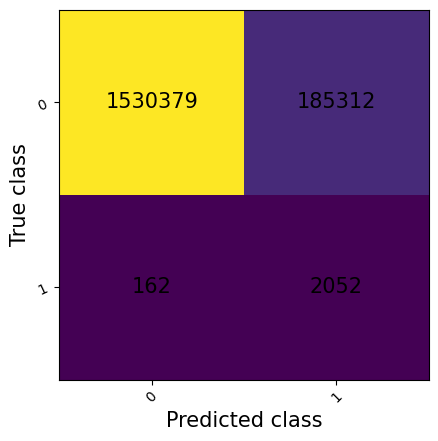

In [116]:
print("f1 = ",f1_score)
print("accuracy = ", acc)
print("precision = ", prec)
print("recall = ",rec)

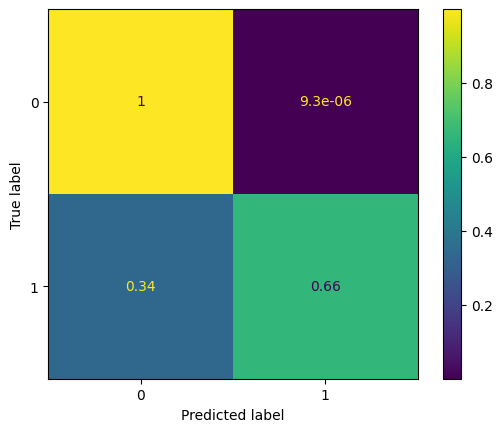

In [93]:
c = ConfusionMatrixDisplay(confusion_matrix=bcm)
c.plot()
plt.show()

# **Explainability using attention weights**

In [1]:




neg = train_dataset.neg_data.sample(20)
pos = train_dataset.pos_data.sample(3)

data = pl.concat([pos, neg])
my_input = collate(data)

out, att = model(my_input)

NameError: name 'train_dataset' is not defined

In [2]:


node_names, node_weights, edge_names, edge_weights = produce_att(att)

G = nx.DiGraph()

# Aggiungi nodi al grafo con colori basati sui pesi

G.add_nodes_from(node_names)
pos = nx.spring_layout(G)  # Puoi usare diverse disposizioni a seconda delle tue esigenze

# Aggiungi archi al grafo con colori basati sui pesi

G.add_edges_from(edge_names)

# Plotta il grafo
nx.draw(G, pos, with_labels=True, node_color=node_weights, edge_color=edge_weights, cmap=plt.cm.Blues, font_weight='bold', node_size=1000)


NameError: name 'produce_att' is not defined

# **Explainability using torch geometric explainers**

In [ ]:


from torch_geometric.explain import GNNExplainer, AttentionExplainer
from torch_geometric.explain import Explainer, ModelConfig


In [ ]:
my_input = next(iter(train_loader))

x = my_input[1].x
edge_index = my_input[1].edge_index
edge_weight = my_input[1].edge_attr
y = torch.tensor(my_input[0].select(pl.col('isFraud')).to_numpy(), dtype=torch.float)

explainer_att = AttentionExplainer()
config = ModelConfig("binary_classification","edge", "raw")

edge_mask = torch.zeros(x.shape[0], dtype=torch.bool)
edge_mask[:10] = True


explainer = GNNExplainer(epoch=200)#model,explainer_att,"model",config)

explaination = explainer(model, x,  edge_index)


TypeError: GNNExplainer.forward() missing 1 required keyword-only argument: 'target'

In [ ]:
from torch_geometric.explain.algorithm import AttentionExplainer, GNNExplainer
from torch_geometric.explain import Explainer, ModelConfig



config = ModelConfig("binary_classification","edge", "raw")

alg = AttentionExplainer()

explainer = Explainer(model,alg,"model",model_config=config, edge_mask_type=MaskType("attributes"))

ValueError: 'edge_mask_type' needs be None or of type 'object' (got 'attributes')

# **Explainability using captum**

In [ ]:
!pip install captum

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 6.4 MB/s eta 0:00:00


In [ ]:
from captum.attr import Saliency, IntegratedGradients

#my_input = next(iter(train_loader))
#test_dataset.collate(test_dataset.data)
# x = input[1].x
# edge_index = input[1].edge_index
# edge_attr = input[1].edge_attr

# target = input[1].y

my_input = collate(validation_dataset.data)#next(iter(test_loader))


y = torch.tensor(my_input[0].select(pl.col('isFraud')).to_numpy(), dtype=torch.float)


def model_forward(edge_mask, data):
    x = data[1].x
    edge_index = data[1].edge_index
    edge_weight = data[1].edge_attr
    #batch = torch.zeros(data.x.shape[0], dtype=int).to(DEVICE)
    out = model(x, edge_index, edge_weight)#, batch, edge_mask)
    return out


def explain(method, data, target=0):
    input_mask = torch.ones(data[1].edge_index.shape[1]).requires_grad_(True).to(DEVICE)
    if method == 'ig':
        ig = IntegratedGradients(model_forward)
        mask = ig.attribute(input_mask, target=target,
                            additional_forward_args=(data,),
                            internal_batch_size=data[1].edge_index.shape[1])
    elif method == 'saliency':
        saliency = Saliency(model_forward)
        mask = saliency.attribute(input_mask, target=target,
                                  additional_forward_args=(data,))
    else:
        raise Exception('Unknown explanation method')

    edge_mask = np.abs(mask.cpu().detach().numpy())
    if edge_mask.max() > 0:  # avoid division by zero
        edge_mask = edge_mask / edge_mask.max()
    return edge_mask




In [ ]:
print(explain('ig',my_input))

RuntimeError: One of the differentiated Tensors appears to not have been used in the graph. Set allow_unused=True if this is the desired behavior.

# **Explainability using Lime**

In [ ]:
!pip install -U lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=58e421cb2ae524beefa3ee73ec21ac0c676d4e025fa333c0b6f30821794d8e80
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


torch.Tensor

In [ ]:
import lime
import lime.lime_tabular

my_input = collate(test_dataset.data)

def wrapped_model(edge_weight):
    """
    Takes in input a numpy array and outputs numpy array with the prediction.
    Necessary since both shap and LIME use numpy arrays to pass parameters.
    """
    model.eval()
    x = my_input[1].x
    edge_index = my_input[1].edge_index

    return model(x, edge_index, edge_weight)

edge_weight = my_input[1].edge_attr
y = torch.tensor(my_input[0].select(pl.col('isFraud')).to_numpy(), dtype=torch.float)

lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    edge_weight, mode="binary_classification",
    class_names=["Median house price"],
    training_labels=y,
    feature_names=['step','type','amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest'],
    verbose=True)



TypeError: min() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (Tensor other)
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


In [ ]:
exp = lime_explainer.explain_instance(x_test[i], wrapped_model)

In [ ]:


my_input = next(iter(train_loader))

x = my_input[1].x
edge_index = my_input[1].edge_index
edge_weight = my_input[1].edge_attr
y = torch.tensor(my_input[0].select(pl.col('isFraud')).to_numpy(), dtype=torch.float)



explainer = lime.lime_tabular.LimeTabularExplainer(edge_weight, feature_names=['step','type','amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest'])


exp = explainer.explain_instance(test[i], rf.predict_proba, num_features=2, top_labels=1)





In [ ]:

import lime
import lime.lime_tabular

def wrapped_model(x):
    """
    Takes in input a numpy array and outputs numpy array with the prediction.
    Necessary since both shap and LIME use numpy arrays to pass parameters.
    """
    model.eval()
    data = test_dataset.collate(test_dataset.data)
    return model(data)

x_test = torch.tensor(test_dataset.data.select(pl.col('step','type','amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest')).to_numpy(), dtype=torch.float)       #test_dataset.collate(test_dataset.data)
y_test = torch.tensor(test_dataset.data.select(pl.col('isFraud')).to_numpy(), dtype=torch.float)




lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    x_test, mode="binary_classification",
    class_names=["Median house price"],
    training_labels=y_test,
    feature_names=['step','type','amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest'],
    verbose=True)



TypeError: min() received an invalid combination of arguments - got (out=NoneType, axis=NoneType, ), but expected one of:
 * ()
 * (Tensor other)
 * (int dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis
 * (name dim, bool keepdim)
      didn't match because some of the keywords were incorrect: out, axis


# **Explainability using SHAP**

In [ ]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.5/533.5 kB 3.3 MB/s eta 0:00:00


In [ ]:
import shap

my_input = collate(test_dataset.data)#next(iter(test_loader))

x = my_input[1].x
edge_index = my_input[1].edge_index
edge_weight = my_input[1].edge_attr
y = torch.tensor(my_input[0].select(pl.col('isFraud')).to_numpy(), dtype=torch.float)

def wrapped_model(edge_weight):
    """
    Takes in input a numpy array and outputs numpy array with the prediction.
    Necessary since both shap and LIME use numpy arrays to pass parameters.
    """
    model.eval()
    x = my_input[1].x
    edge_index = my_input[1].edge_index

    return model(x, edge_index, edge_weight)


explainer = shap.Explainer(wrapped_model, edge_weight, feature_names=['step','type','amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest'])
shap_values = explainer.shap_values(edge_weight)

TypeError: 'Tensor' object is not callable

# **Explainability using EdgeSHAPer**

In [ ]:
!pip install rdkit


In [ ]:
!pip install git+https://github.com/c-feldmann/rdkit_heatmaps
!pip install git+https://github.com/AndMastro/edgeshaper

  Cloning https://github.com/c-feldmann/rdkit_heatmaps to /tmp/pip-req-build-zcy4di5g
  Running command git clone --filter=blob:none --quiet https://github.com/c-feldmann/rdkit_heatmaps /tmp/pip-req-build-zcy4di5g
  Resolved https://github.com/c-feldmann/rdkit_heatmaps to commit 3ed507ab837caaa1c10d2ae5fdf31d1cd135a777
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/AndMastro/edgeshaper to /tmp/pip-req-build-i7e_a3kd
  Running command git clone --filter=blob:none --quiet https://github.com/AndMastro/edgeshaper /tmp/pip-req-build-i7e_a3kd
  Resolved https://github.com/AndMastro/edgeshaper to commit 59a4d25295a53a8996d68d5f0c6f57a93be2f817
ERROR: git+https://github.com/AndMastro/edgeshaper does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.


In [ ]:
# from edgeshaper import edgeshaper
import edgeshaper



input = test_dataset.collate(test_dataset.data)
x = input[1].x
edge_index = input[1].edge_index
edge_attr = input[1].edge_attr

target = input[1].y

explainer = edgeshaper.Edgeshaper(model,x,edge_index, edge_weight = edge_attr )

attributions, delta = explainer.explain()


# for data_tmp in train_loader:
#   data = data_tmp
#   break

# edge_index = data[1].edge_index
# x = data[1].x
# device = "cuda" or "cpu"
# target_class = data[1].y.to(dtype=torch.long) #class label for which to perform explanations

# edges_explanations = edgeshaper(model, x, edge_index, M = 100, target_class = target_class, device = "cpu", edge_weight = data[1].edge_attr)

  0%|          | 0/1717905 [00:00<?, ?it/s]

first_model =       FraudDetectionModuleOld(
        (dropout): Dropout(p=0.2, inplace=False)
        (gnn): GCNConv(1, 128)
        (gnn1): GCNConv(128, 128)
        (gnn2): GCNConv(128, 64)
        (linear): Linear(in_features=135, out_features=128, bias=True)
        (linear2): Linear(in_features=128, out_features=128, bias=True)
        (classifier): Linear(in_features=128, out_features=1, bias=True)
        (sigmoid): Sigmoid()
        (relu): ReLU()
      ), fake validation
      